In [8]:
# import packages and read in full dataset (pca features)
from read_data import get_all_data, split_and_stratify_data, get_balanced_df

import warnings
warnings.filterwarnings('ignore') # for looks..

import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix

full_dataset = get_all_data(number_of_pca_features = 100)
full_dataset.head()

GroundTruth.csv read. Processing/searching for image data. May take a few minutes if process_images_again == True.

Existing image data read..


,image,cancer_type,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,ISIC_0024306.jpg,NV,2.227468,-3.264277,-1.167765,0.924474,-2.286435,1.804567,0.273134,0.418798,...,-0.099027,-0.009333,-0.051041,-0.019836,-0.134981,0.083766,0.020061,-0.062348,-0.155223,-0.037895
1,ISIC_0024307.jpg,NV,1.068419,-1.742836,-2.110399,0.040784,-1.148290,0.792414,0.011848,0.533355,...,-0.039695,-0.032529,0.015959,-0.021628,-0.059418,-0.019899,0.006778,0.107662,-0.039652,-0.009560
2,ISIC_0024308.jpg,NV,0.983078,-4.920764,0.617789,1.684504,-0.617451,-0.853629,-0.934357,0.139916,...,0.103498,0.018952,0.015636,0.057682,0.015973,0.040700,0.187303,-0.050769,0.090087,0.106535
3,ISIC_0024309.jpg,NV,4.042187,-1.004445,-1.730627,0.354093,0.451159,-2.407673,0.339228,-0.318631,...,-0.080027,-0.027284,0.011457,0.087806,-0.070773,-0.000180,-0.049357,0.022274,0.046849,-0.057677
4,ISIC_0024310.jpg,MEL,0.925909,-0.801578,-0.337978,1.529686,-0.320369,0.183890,-0.863793,0.924670,...,0.221153,0.113545,0.000518,0.071552,0.341293,-0.269370,0.305026,-0.021116,0.292971,0.065647


In [9]:
# split into train test and validation datasets
train, test, validate = split_and_stratify_data(full_dataset, random = 2)

# balance the training set?
#train = get_balanced_df(train, val_size = 1000, col = 'cancer_type')

# create X and y train, test and validate sets
X_train = train.iloc[:,2:-1]
X_test = test.iloc[:,2:-1]
X_validate = validate.iloc[:,2:-1]

y_train = train.iloc[:,1]
y_test = test.iloc[:,1]
y_validate = validate.iloc[:,1]

print('Training Set Cancer Counts')
print(y_train.value_counts())
print('Test Set Cancer Counts')
print(y_test.value_counts())
print('Validation Set Cancer Counts')
print(y_validate.value_counts())

Training Set Cancer Counts
NV       5364
MEL       890
BKL       879
BCC       411
AKIEC     262
VASC      114
DF         92
Name: cancer_type, dtype: int64
Test Set Cancer Counts
NV       670
MEL      111
BKL      110
BCC       51
AKIEC     33
VASC      14
DF        12
Name: cancer_type, dtype: int64
Validation Set Cancer Counts
NV       671
MEL      112
BKL      110
BCC       52
AKIEC     32
VASC      14
DF        11
Name: cancer_type, dtype: int64


# Random Forest Classifier

Model Accuracy is 67.47%


 Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.00      0.00      0.00        32
         BCC       1.00      0.02      0.04        52
         BKL       0.75      0.03      0.05       110
          DF       0.00      0.00      0.00        11
         MEL       0.00      0.00      0.00       112
          NV       0.67      1.00      0.80       671
        VASC       1.00      0.14      0.25        14

    accuracy                           0.67      1002
   macro avg       0.49      0.17      0.16      1002
weighted avg       0.60      0.67      0.55      1002

Confusion Matrix is here:



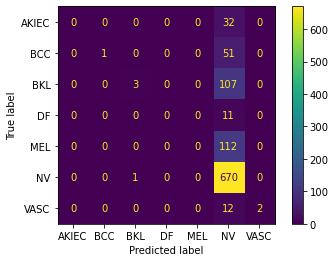

In [10]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=75, random_state=42, class_weight = 'balanced')
forest_clf.fit(X_train, y_train)
y_pred = forest_clf.predict(X_validate)

print(f'Model Accuracy is {round(accuracy_score(y_validate, y_pred),4)*100}%\n')

print('\n Here is the classification report. \n')
print(classification_report(y_validate, y_pred))

print('Confusion Matrix is here:\n')
plot_confusion_matrix(forest_clf, X_validate, y_validate)  
plt.show()  


Big problem with misclassification of many data points as the most popular 'NV' cancer type.. Tried playing around with balancing the train set through function and through 'class_weight' parameter in random forest classifier, but couldn't improve performance consistently.

#  Gaussian Na¨ıve Bayes

Model Accuracy is 63.27%


 Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.40      0.19      0.26        32
         BCC       0.35      0.21      0.27        52
         BKL       0.21      0.12      0.15       110
          DF       0.08      0.09      0.09        11
         MEL       0.28      0.50      0.36       112
          NV       0.80      0.81      0.80       671
        VASC       0.50      0.36      0.42        14

    accuracy                           0.63      1002
   macro avg       0.38      0.32      0.33      1002
weighted avg       0.63      0.63      0.62      1002

Confusion Matrix is here:



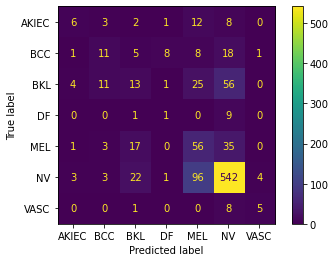

In [11]:
from sklearn.naive_bayes import GaussianNB

gaussian_clf = GaussianNB()
gaussian_clf.fit(X_train, y_train)
y_pred = gaussian_clf.predict(X_validate)

print(f'Model Accuracy is {round(accuracy_score(y_validate, y_pred),4)*100}%\n')

print('\n Here is the classification report. \n')
print(classification_report(y_validate, y_pred))

print('Confusion Matrix is here:\n')
plot_confusion_matrix(gaussian_clf, X_validate, y_validate)  
plt.show()  

Model was trained incredibly fast and results seem decent compared with random forest..

# Logistic Regression

Model Accuracy is 70.56%


 Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.50      0.25      0.33        32
         BCC       0.57      0.52      0.55        52
         BKL       0.44      0.28      0.34       110
          DF       0.00      0.00      0.00        11
         MEL       0.39      0.12      0.19       112
          NV       0.76      0.93      0.83       671
        VASC       0.44      0.29      0.35        14

    accuracy                           0.71      1002
   macro avg       0.44      0.34      0.37      1002
weighted avg       0.65      0.71      0.66      1002

Confusion Matrix is here:



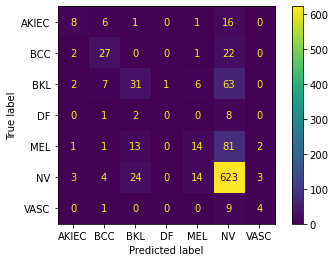

In [12]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression(random_state=42)
logreg_clf.fit(X_train, y_train)
y_pred = logreg_clf.predict(X_validate)

print(f'Model Accuracy is {round(accuracy_score(y_validate, y_pred),4)*100}%\n')

print('\n Here is the classification report. \n')
print(classification_report(y_validate, y_pred))

print('Confusion Matrix is here:\n')
plot_confusion_matrix(logreg_clf, X_validate, y_validate)  
plt.show()  

Again not bad - still pretty fast as well.

# k-Nearest Neighbors

Model Accuracy is 71.16%


 Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.31      0.25      0.28        32
         BCC       0.37      0.37      0.37        52
         BKL       0.43      0.41      0.42       110
          DF       0.00      0.00      0.00        11
         MEL       0.40      0.19      0.26       112
          NV       0.81      0.92      0.86       671
        VASC       0.00      0.00      0.00        14

    accuracy                           0.71      1002
   macro avg       0.33      0.31      0.31      1002
weighted avg       0.66      0.71      0.68      1002

Confusion Matrix is here:



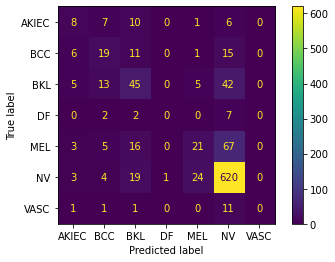

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_validate)

print(f'Model Accuracy is {round(accuracy_score(y_validate, y_pred),4)*100}%\n')

print('\n Here is the classification report. \n')
print(classification_report(y_validate, y_pred))

print('Confusion Matrix is here:\n')
plot_confusion_matrix(knn_clf, X_validate, y_validate)  
plt.show()  

Again not bad - still pretty fast as well.

# Kernel Support Vector Machines

Model Accuracy is 72.06%


 Here is the classification report. 

              precision    recall  f1-score   support

       AKIEC       0.18      0.12      0.15        32
         BCC       0.46      0.33      0.38        52
         BKL       0.51      0.32      0.39       110
          DF       0.00      0.00      0.00        11
         MEL       0.61      0.15      0.24       112
          NV       0.77      0.97      0.86       671
        VASC       0.00      0.00      0.00        14

    accuracy                           0.72      1002
   macro avg       0.36      0.27      0.29      1002
weighted avg       0.67      0.72      0.67      1002

Confusion Matrix is here:



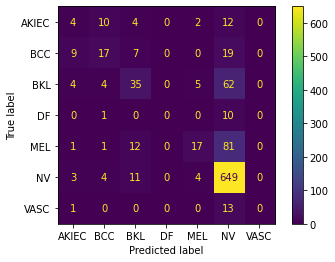

In [14]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='rbf', random_state=42)
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_validate)

print(f'Model Accuracy is {round(accuracy_score(y_validate, y_pred),4)*100}%\n')

print('\n Here is the classification report. \n')
print(classification_report(y_validate, y_pred))

print('Confusion Matrix is here:\n')
plot_confusion_matrix(svm_clf, X_validate, y_validate)  
plt.show()  


Again - not bad..